In [1]:
# !git checkout permutation-delegator

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Data

In [2]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y=y, test_size=6)

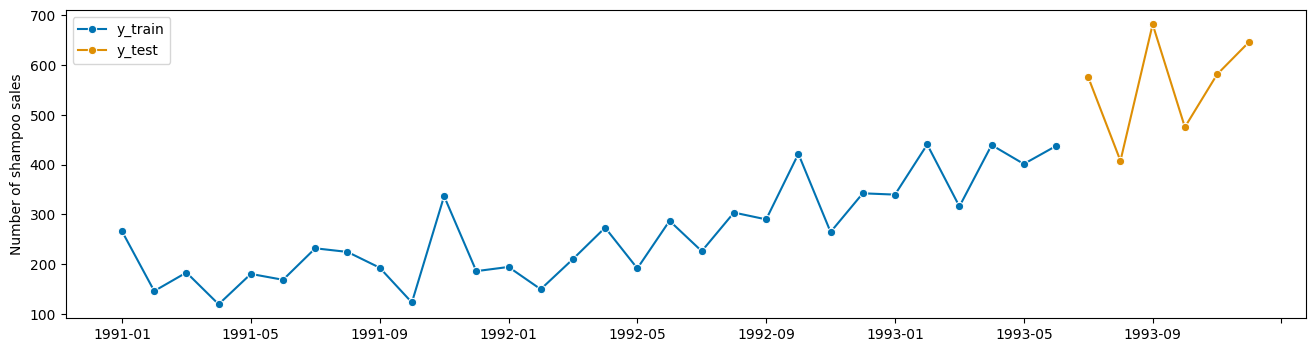

In [3]:
from sktime.utils.plotting import plot_series

fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"])
fig;

## Cross-validation

In [4]:
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = ForecastingHorizon(y_test.index, is_relative=False).to_relative(
    cutoff=y_train.index[-1]
)

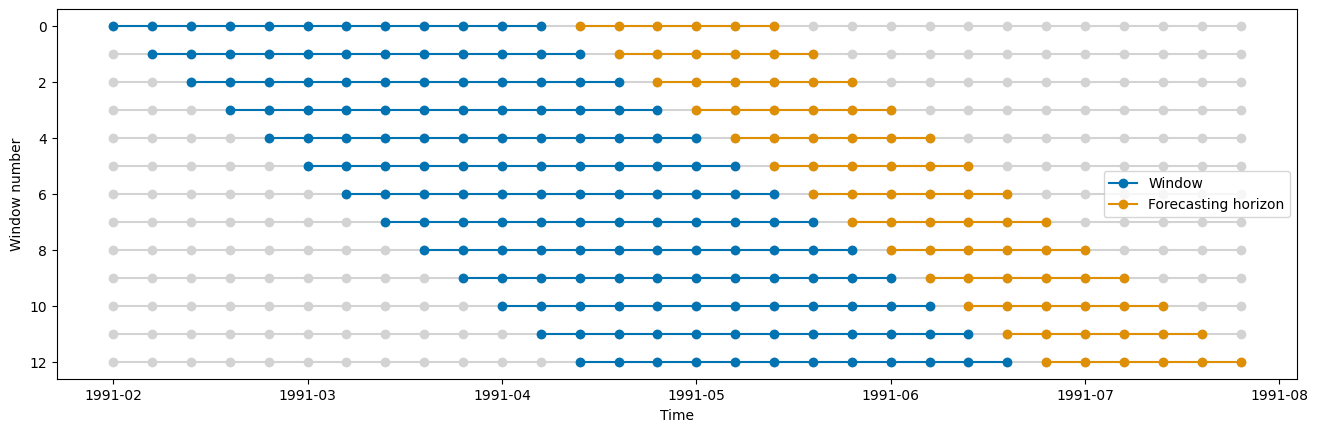

In [5]:
cv = SlidingWindowSplitter(fh=fh, window_length=12, step_length=1)
plot_windows(cv=cv, y=y_train)

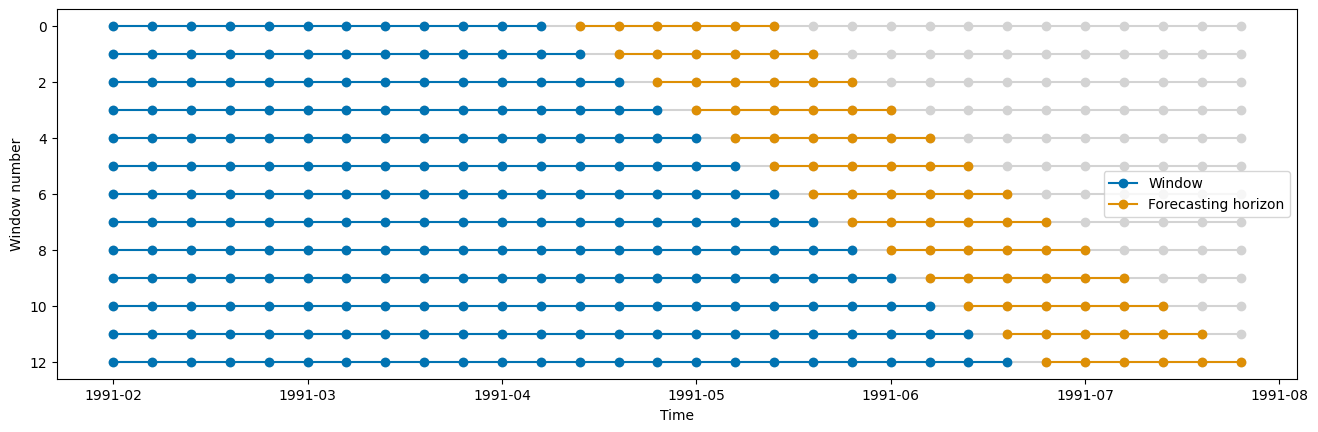

In [6]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=12, step_length=1)
plot_windows(cv=cv, y=y_train)

In [7]:
# get number of total splits (folds)
cv.get_n_splits(y=y_train)

13

## Grid search

In [8]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError


forecaster = ExponentialSmoothing()
param_grid = {
    "sp": [4, 6, 12],
    "seasonal": ["add", "mul"],
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

Fitting 13 folds for each of 24 candidates, totalling 312 fits


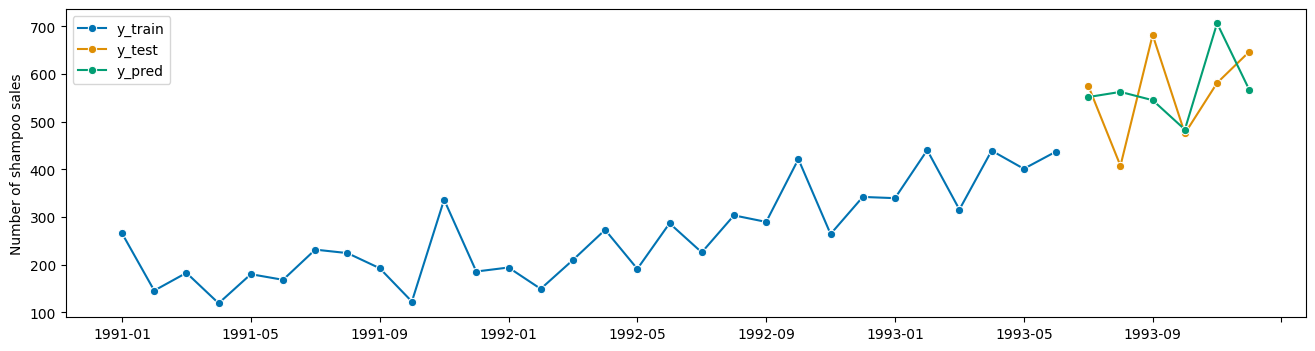

In [9]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax;

In [10]:
from sktime.performance_metrics.forecasting import MeanSquaredError

rmse = MeanSquaredError(square_root=True)

round(rmse(y_true=y_test, y_pred=y_pred), 4)

104.424

In [11]:
gscv.best_params_

{'damped_trend': True, 'seasonal': 'add', 'sp': 12, 'trend': 'mul'}

In [12]:
gscv.best_forecaster_

ExponentialSmoothing(damped_trend=True, seasonal='add', sp=12, trend='mul')

In [13]:
gscv.cv_results_.head()

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,98.635359,0.125913,0.003807,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",7.0
1,98.327241,0.117024,0.003555,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",6.0
2,104.567201,0.108024,0.003436,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",13.0
3,112.555601,0.131744,0.003789,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",16.0
4,147.065358,0.112284,0.003623,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",22.0


## Grid search with pipeline

For tuning parameters with compositions such as pipelines, we can use the \<estimator\>__\<parameter\> syntax known from [scikit-learn](https://scikit-learn.org/stable/modules/grid_search.html#composite-estimators-and-parameter-spaces). For multiple levels of nesting, we can use the same syntax with two underscores, e.g. `forecaster__transformer__parameter`.

In [14]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, MinMaxScaler
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("minmax", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

# using dunder notation to access inner objects/params as in sklearn
param_grid = {
    # deseasonalizer
    "deseasonalizer__model": ["multiplicative", "additive"],
    # power
    "power__transformer__method": ["yeo-johnson", "box-cox"],
    "power__transformer__standardize": [True, False],
    # forecaster
    "forecaster__sp": [4, 6, 12],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__trend": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),  # set custom scoring function
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

Fitting 13 folds for each of 192 candidates, totalling 2496 fits


In [15]:
round(rmse(y_true=y_test, y_pred=y_pred), 4)

170.8909

In [16]:
gscv.best_params_

{'deseasonalizer__model': 'additive',
 'forecaster__damped_trend': False,
 'forecaster__seasonal': 'add',
 'forecaster__sp': 4,
 'forecaster__trend': 'add',
 'power__transformer__method': 'yeo-johnson',
 'power__transformer__standardize': False}

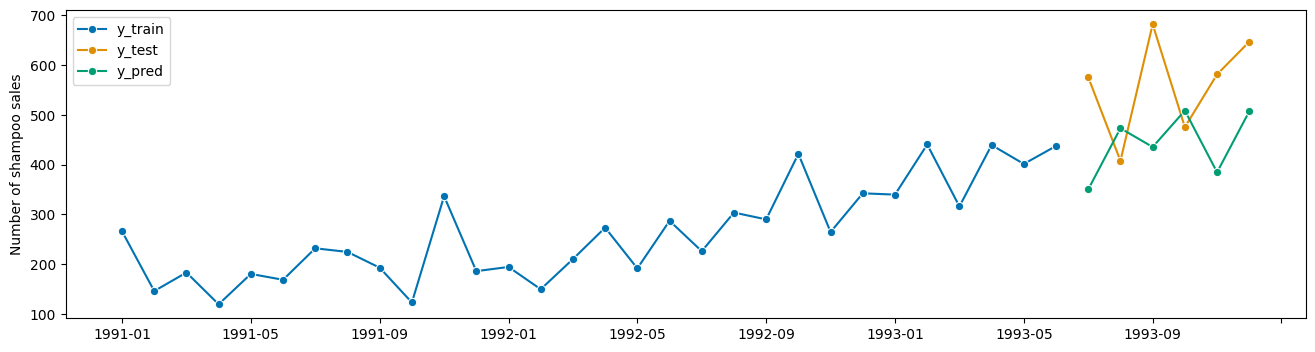

In [17]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
fig;

## Model selection

There are three ways ways to select a model out of multiple models:
1) `ForecastingGridSearchCV`
2) `MultiplexForecaster`
3) `relative_loss` or `RelativeLoss`

#### 1) `ForecastingGridSearchCV`
We can use `ForecastingGridSearchCV` to fit multiple models and find the best using equivalent notations as in `sklearn`. We can either have...
* We can either do: `param_grid: List[Dict]`
* Or we just have a list of forecasters in the grid: `forecaster": [NaiveForecaster(), STLForecaster()]`

In [18]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.naive import NaiveForecaster

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("minmax2", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("forecaster", NaiveForecaster()),
    ]
)

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=[
        {
            "scaler__transformer__with_scaling": [True, False],
            "forecaster": [NaiveForecaster()],
            "forecaster__strategy": ["drift", "last", "mean"],
            "forecaster__sp": [4, 6, 12],
        },
        {
            "scaler__transformer__with_scaling": [True, False],
            "forecaster": [STLForecaster(), ThetaForecaster()],
            "forecaster__sp": [4, 6, 12],
        },
    ],
    cv=cv,
    n_jobs=-1,
)
gscv.fit(y)
gscv.best_params_

{'forecaster': NaiveForecaster(sp=4),
 'forecaster__sp': 4,
 'forecaster__strategy': 'last',
 'scaler__transformer__with_scaling': True}

#### 2) `MultiplexForecaster`
We can use the `MultiplexForecaster` to compare the performance of different forecasters. This approach might be useful if we want to compare the performance of different models that have been tuned and fitted already separately. The `MultiplexForecaster` is just a forecaster compostition that provides a parameters `selected_forecaster: List[str]` that can be tuned with a grid search. 


In [21]:
from sktime.forecasting.compose import MultiplexForecaster

forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster()),
        ("stl", STLForecaster()),
        ("theta", ThetaForecaster()),
    ]
)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid={"selected_forecaster": ["naive", "stl", "theta"]},
    cv=cv,
    n_jobs=-1,
)
gscv.fit(y)
gscv.best_params_

{'selected_forecaster': 'theta'}

#### 3) `relative_loss` or `RelativeLoss`
We can compare two models on a given test data by means of a relative loss calculation. This is however not doing any cross-validation compared to the above model selection approaches 1) and 2).

In [43]:
from sktime.performance_metrics.forecasting import (
    mean_squared_error,
    mean_absolute_error,
)

forecaster_1 = NaiveForecaster(strategy="drift")
forecaster_2 = STLForecaster()

forecaster_1.fit(y_train)
forecaster_2.fit(y_train)

y_pred_1 = forecaster_1.predict(fh=fh)
y_pred_2 = forecaster_2.predict(fh=fh)

print("mean_absolute_error")
print("\t", mean_absolute_error(y_test, y_pred_1))
print("\t", mean_absolute_error(y_test, y_pred_2))
print("mean_squared_error")
print("\t", mean_squared_error(y_test, y_pred_1))
print("\t", mean_squared_error(y_test, y_pred_2))

mean_absolute_error
	 117.22068965517242
	 134.8812535341722
mean_squared_error
	 19040.658692033296
	 25483.896847856584


In [46]:
from sktime.performance_metrics.forecasting import relative_loss

relative_loss(y_true=y_test, y_pred=y_pred_1, y_pred_benchmark=y_pred_2)

0.8690658381631553

The relative loss function uses the mean_absolute_error by default as error metric. The best score for a relative loss is `0`. If the score is `>1`, the forecast given as `y_pred` is worse than the given benchmark forecast in `y_pred_benchmark`. If we want to customize the relative loss, we can use the `RelativeLoss` scorer class and e.g. provide a custom loss function.

In [49]:
from sktime.performance_metrics.forecasting import RelativeLoss

relative_mse = RelativeLoss(relative_loss_function=mean_squared_error)
relative_mse(y_true=y_test, y_pred=y_pred_1, y_pred_benchmark=y_pred_2)

0.7471643291333907

## Model backtesting

After fitting a model, we can evaluate the model error in the past similar to a cross-validation. For this we can use the `evaluate` function

In [193]:
from sktime.forecasting.model_evaluation import evaluate

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y,
    cv=ExpandingWindowSplitter(fh=fh, initial_window=24, step_length=3),
    scoring=MeanSquaredError(square_root=True),
    return_data=True,
)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,91.172072,0.089141,0.030988,24,1992-12,1991-01 266.0 1991-02 145.9 1991-03 1...,1993-01 339.7 1993-02 440.4 1993-03 3...,1993-01 347.710409 1993-02 254.561536 19...
1,131.614040,0.075653,0.030751,27,1993-03,1991-01 266.0 1991-02 145.9 1991-03 1...,1993-04 439.3 1993-05 401.3 1993-06 4...,1993-04 564.591910 1993-05 346.290730 19...
2,135.626757,0.083241,0.027170,30,1993-06,1991-01 266.0 1991-02 145.9 1991-03 1...,1993-07 575.5 1993-08 407.6 1993-09 6...,1993-07 437.497213 1993-08 496.139182 19...


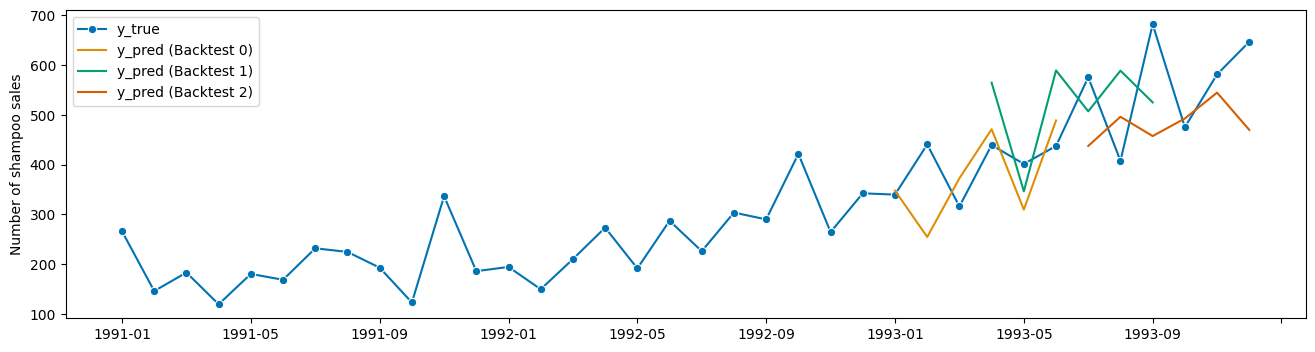

In [196]:
fig, ax = plot_series(
    y,
    results["y_pred"].iloc[0],
    results["y_pred"].iloc[1],
    results["y_pred"].iloc[2],
    markers=["o", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(3)],
)
ax.legend();

## Tuning implicite hyper-parameters.

An implicite hyper-parameter can be an architecture and design decision that has an impact on the model error metric. An example for an implicite hyperparameter can be the number of layers of an artificial neural network. For pipelining, there are two implicite hyper-parameters that we might want to tune.
1) Combination of transformers
2) Permutation of transformers

### Combination of transformers

Given a set of four different transformers, we would like to know which combination of the four transformers is having the best error. So in total there are 4² = 16 different combinations. We can use the `GridSearchCV` to find the best combination.

In [20]:
steps = [
    ("detrender", Detrender()),
    ("deseasonalizer", Deseasonalizer()),
    ("power", TabularToSeriesAdaptor(PowerTransformer())),
    ("scaler", TabularToSeriesAdaptor(RobustScaler())),
    ("forecaster", ExponentialSmoothing()),
]

In `sktime` there is a transformer composition called `OptionalPassthrough()` which gets a transformer as an argument and a param `passthrough: bool`. Setting `passthrough=True` will return an identity transformation for the given data. Setting `passthrough=False` will apply the given inner transformer on the data.

In [21]:
from sktime.transformations.series.compose import OptionalPassthrough

transformer = OptionalPassthrough(transformer=Detrender(), passthrough=True)
transformer.fit_transform(y_train).head()

1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

In [22]:
y_train.head()

1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

In [23]:
transformer = OptionalPassthrough(transformer=Detrender(), passthrough=False)
transformer.fit_transform(y_train).head()

1991-01    130.376344
1991-02      1.503263
1991-03     29.930182
1991-04    -42.642900
1991-05      9.584019
Freq: M, dtype: float64

In [197]:
forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("power", OptionalPassthrough(TabularToSeriesAdaptor(PowerTransformer()))),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", ExponentialSmoothing()),
    ]
)

param_grid = {
    "detrender__passthrough": [True, False],
    "deseasonalizer__passthrough": [True, False],
    "power__passthrough": [True, False],
    "scaler__passthrough": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
)
gscv.fit(y_train)

Fitting 13 folds for each of 16 candidates, totalling 208 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6], dtype='int64', is_relative=True),
                                                   initial_window=12),
                        forecaster=TransformedTargetForecaster(steps=[('detrender',
                                                                       OptionalPassthrough(transformer=Detrender())),
                                                                      ('deseasonalizer',
                                                                       OptionalPassthrough(transformer=Deseasonalizer())),
                                                                      ('power',
                                                                       OptionalPassthrough(transform...
                                                                       OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler()))),
                                               

Best performing combination of transformers:

In [198]:
gscv.best_params_

{'deseasonalizer__passthrough': True,
 'detrender__passthrough': False,
 'power__passthrough': True,
 'scaler__passthrough': True}

Worst performing combination of transformers:

In [26]:
# worst params
gscv.cv_results_.sort_values(by="mean_test_MeanSquaredError", ascending=True).iloc[-1][
    "params"
]

{'deseasonalizer__passthrough': False,
 'detrender__passthrough': True,
 'power__passthrough': False,
 'scaler__passthrough': True}

### Permutation of transformers

Given a set of four different transformers, we would like to know which permutation (ordering) of the four transformers is having the best error. In total there are 4! = 24 different permutations. We can use the `GridSearchCV` to find the best permutation.

In [27]:
from sktime.forecasting.compose import Permute

In [28]:
forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("power", OptionalPassthrough(TabularToSeriesAdaptor(PowerTransformer()))),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", ExponentialSmoothing()),
    ]
)

param_grid = {
    "permutation": [
        ["detrender", "deseasonalizer", "power", "scaler", "forecaster"],
        ["power", "scaler", "detrender", "deseasonalizer", "forecaster"],
        ["scaler", "deseasonalizer", "power", "detrender", "forecaster"],
        ["deseasonalizer", "power", "scaler", "detrender", "forecaster"],
    ]
}
permuted = Permute(estimator=forecaster, permutation=None)

gscv = ForecastingGridSearchCV(
    forecaster=permuted,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
)

permuted = gscv.fit(y, fh=fh)

Fitting 19 folds for each of 4 candidates, totalling 76 fits


In [29]:
permuted.cv_results_

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,104.529303,0.107906,0.024690,"{'permutation': ['detrender', 'deseasonalizer'...",2.0
1,108.840723,0.104594,0.025215,"{'permutation': ['power', 'scaler', 'detrender...",3.5
2,95.243942,0.105438,0.024116,"{'permutation': ['scaler', 'deseasonalizer', '...",1.0
3,108.840723,0.105166,0.025788,"{'permutation': ['deseasonalizer', 'power', 's...",3.5


In [30]:
gscv.best_params_

{'permutation': ['scaler',
  'deseasonalizer',
  'power',
  'detrender',
  'forecaster']}

In [31]:
# worst params
gscv.cv_results_.sort_values(by="mean_test_MeanSquaredError", ascending=True).iloc[-1][
    "params"
]

{'permutation': ['deseasonalizer',
  'power',
  'scaler',
  'detrender',
  'forecaster']}

## Putting it all together: autoML-like pipeline

Taking all incredients from above examples, we can build an forecaster that comes close to what is usually called autoML. Main incredients for this are the following compositions:
- `TransformedTargetForecaster`
- `ForecastingPipeline`
- `ForecastingGridSearchCV`
- `OptionalPassthrough`
- `Permute`

In [201]:
# All permutations. There is a function get_all_permutations() in functions.py that can
# be used to get all possible permutations based on given steps

permutations = [
    ["detrender", "deseasonalizer", "scaler", "forecaster"],
    ["detrender", "scaler", "deseasonalizer", "forecaster"],
    ["deseasonalizer", "detrender", "scaler", "forecaster"],
    ["deseasonalizer", "scaler", "detrender", "forecaster"],
    ["scaler", "detrender", "deseasonalizer", "forecaster"],
    ["scaler", "deseasonalizer", "detrender", "forecaster"],
]

In [202]:
pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", ExponentialSmoothing(sp=4)),
    ]
)
permuted_y = Permute(estimator=pipe_y, permutation=None)

param_grid = {
    "permutation": permutations,
    "estimator__detrender__passthrough": [True, False],
    "estimator__deseasonalizer__passthrough": [True, False],
    "estimator__scaler__passthrough": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=permuted_y,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
    error_score="raise",
)

gscv.fit(y=y_train, fh=fh)

Fitting 13 folds for each of 48 candidates, totalling 624 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6], dtype='int64', is_relative=True),
                                                   initial_window=12),
                        error_score='raise',
                        forecaster=Permute(estimator=TransformedTargetForecaster(steps=[('detrender',
                                                                                         OptionalPassthrough(transformer=Detrender())),
                                                                                        ('deseasonalizer',
                                                                                         OptionalPassthrough(transformer=Deseasonalizer())),...
                                                     'deseasonalizer', 'scaler',
                                                     'forecaster'],
                                                    ['detrender', 'scaler',
                                           

In [203]:
gscv.cv_results_["mean_test_MeanSquaredError"].min()

79.6772676143985

In [204]:
gscv.cv_results_["mean_test_MeanSquaredError"].max()

99.99869006490903

In [205]:
gscv.best_params_

{'estimator__deseasonalizer__passthrough': True,
 'estimator__detrender__passthrough': False,
 'estimator__scaler__passthrough': True,
 'permutation': ['detrender', 'deseasonalizer', 'scaler', 'forecaster']}

In [206]:
# worst params
gscv.cv_results_.sort_values(by="mean_test_MeanSquaredError", ascending=True).iloc[-1][
    "params"
]

{'estimator__deseasonalizer__passthrough': True,
 'estimator__detrender__passthrough': True,
 'estimator__scaler__passthrough': True,
 'permutation': ['detrender', 'deseasonalizer', 'scaler', 'forecaster']}

### With exog data

In [207]:
from sktime.datasets import load_macroeconomic

data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=40)

fh = ForecastingHorizon(np.arange(1, 41), is_relative=True)

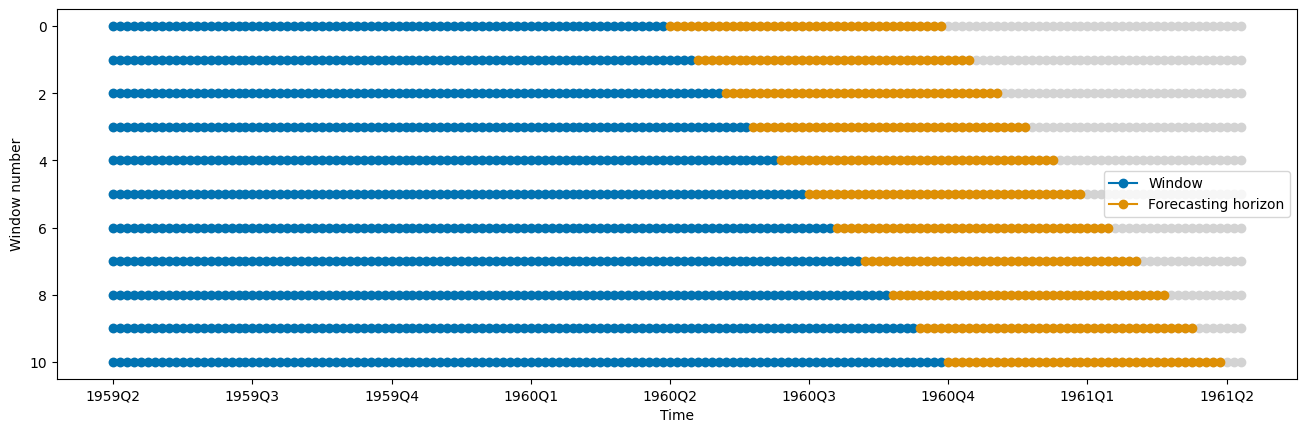

In [208]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=80, step_length=4)
plot_windows(cv=cv, y=y_train)

In [209]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=40)
fh = ForecastingHorizon(np.arange(1, 41), is_relative=True)

pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", StatsForecastAutoARIMA(sp=4)),
    ]
)
permuted_y = Permute(pipe_y, permutation=None)

pipe_X = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", permuted_y),
    ]
)
permuted_X = Permute(pipe_X, permutation=None)

In [210]:
gscv = ForecastingGridSearchCV(
    forecaster=permuted_X,
    param_grid={
        "estimator__forecaster__permutation": [
            ["detrender", "deseasonalizer", "scaler", "forecaster"],
            ["scaler", "detrender", "deseasonalizer", "forecaster"],
        ],
        "permutation": [
            ["detrender", "deseasonalizer", "scaler", "forecaster"],
            ["scaler", "detrender", "deseasonalizer", "forecaster"],
        ],
        "estimator__forecaster__estimator__scaler__passthrough": [True, False],
        "estimator__scaler__passthrough": [True, False],
    },
    cv=cv,
    error_score="raise",
    scoring=MeanSquaredError(square_root=True),
    n_jobs=-1,
)

gscv.fit(y=y_train, X=X_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40],
           dtype='int64', is_relative=True),
                                                   initial_window=80,
                                                   step_length=4),
                        error_score='raise',
                        forecaster=Permute(estimator=TransformedTargetForecaster(steps=[('detrender',
                                                                                         Op...
                                    'estimator__forecaster__permutation': [['detrender',
                                                                            'deseasonalizer',
                                                                            'scaler',
                                                

In [211]:
gscv.cv_results_["mean_test_MeanSquaredError"].min()

1.9841003805900237

In [212]:
gscv.cv_results_["mean_test_MeanSquaredError"].max()

2.122798005818398

In [213]:
gscv.best_params_

{'estimator__forecaster__estimator__scaler__passthrough': True,
 'estimator__forecaster__permutation': ['detrender',
  'deseasonalizer',
  'scaler',
  'forecaster'],
 'estimator__scaler__passthrough': False,
 'permutation': ['detrender', 'deseasonalizer', 'scaler', 'forecaster']}

In [214]:
# worst params
gscv.cv_results_.sort_values(by="mean_test_MeanSquaredError", ascending=True).iloc[-1][
    "params"
]

{'estimator__forecaster__estimator__scaler__passthrough': True,
 'estimator__forecaster__permutation': ['scaler',
  'detrender',
  'deseasonalizer',
  'forecaster'],
 'estimator__scaler__passthrough': True,
 'permutation': ['scaler', 'detrender', 'deseasonalizer', 'forecaster']}